In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import os
import numpy as np
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision.utils import save_image
import matplotlib.pyplot as plt

In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
TRAIN_DIR_H = "/kaggle/input/cyclegan/horse2zebra/horse2zebra/trainA"
TRAIN_DIR_Z = "/kaggle/input/cyclegan/horse2zebra/horse2zebra/trainB"
BATCH_SIZE = 1
LEARNING_RATE = 2e-5
LAMBDA_IDENTITY = 0.0
LAMBDA_CYCLE = 10
NUM_WORKERS = 4
NUM_EPOCHS = 10
LOAD_MODEL = False
SAVE_MODEL = True
CHECKPOINT_GEN_H = "/kaggle/working/genh.pth.tar"  
CHECKPOINT_GEN_Z = "/kaggle/working/genz.pth.tar"
CHECKPOINT_CRITIC_H = "/kaggle/working/critich.pth.tar"
CHECKPOINT_CRITIC_Z = "/kaggle/working/criticz.pth.tar"

transforms = A.Compose(
    [
        A.Resize(width=256, height=256),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        A.HueSaturationValue(p=0.2), 
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255),
        ToTensorV2(),
    ],
    additional_targets={"image0": "image"},
)

In [3]:
if not os.path.exists('/kaggle/working/saved_images'):
    os.makedirs('/kaggle/working/saved_images')

In [4]:
class CustomImageDataset(Dataset):
    
    def __init__(self,root_z,root_h,transform=None):
        self.root_z = root_z
        self.root_h = root_h
        self.transform = transform if transform is not None else A.Compose([
            A.Resize(width=256, height=256),
            A.HorizontalFlip(p=0.5),
            A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255),
            ToTensorV2(),
        ])
        
        self.z_img = os.listdir(root_z)
        self.h_img = os.listdir(root_h)
        self.length_dataset = max(len(self.z_img),len(self.h_img))
        self.z_len = len(self.z_img)
        self.h_len = len(self.h_img)
        
    def __len__(self):
        return self.length_dataset
    
    
    def __getitem__(self,index):
        z_img = self.z_img[index%self.z_len]
        h_img = self.h_img[index%self.h_len]
        
        z_path = os.path.join(self.root_z,z_img)
        h_path = os.path.join(self.root_h,h_img)
        
        z_img = np.array(Image.open(z_path).convert('RGB'))
        h_img = np.array(Image.open(h_path).convert('RGB'))
        
        if self.transform:
            augmentation = self.transform(image=z_img, image0=h_img)
            z_img = augmentation['image']
            h_img = augmentation['image0']
        return z_img, h_img

In [5]:
z_len = len(os.listdir(TRAIN_DIR_Z))
h_len = len(os.listdir(TRAIN_DIR_H))

print("Length of trainA (horses):", h_len)
print("Length of trainB (zebras):", z_len)

Length of trainA (horses): 1067
Length of trainB (zebras): 1334


## **Generator code**

In [6]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, use_act=True, **kwargs):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, padding_mode="reflect", **kwargs)
            if down
            else nn.ConvTranspose2d(in_channels, out_channels, **kwargs),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True) if use_act else nn.Identity(),
        )

    def forward(self, x):
        return self.conv(x)

In [7]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            ConvBlock(channels, channels, kernel_size=3, padding=1),
            ConvBlock(channels, channels, use_act=False, kernel_size=3, padding=1),
        )

    def forward(self, x):
        return x + self.block(x)


In [8]:
class Generator(nn.Module):
    def __init__(self, img_channels, num_features=64, num_residuals=9):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(
                img_channels,
                num_features,
                kernel_size=7,
                stride=1,
                padding=3,
                padding_mode="reflect",
            ),
            nn.InstanceNorm2d(num_features),
            nn.ReLU(inplace=True),
        )
        self.down_blocks = nn.ModuleList(
            [
                ConvBlock(
                    num_features, num_features * 2, kernel_size=3, stride=2, padding=1
                ),
                ConvBlock(
                    num_features * 2,
                    num_features * 4,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                ),
            ]
        )
        self.res_blocks = nn.Sequential(
            *[ResidualBlock(num_features * 4) for _ in range(num_residuals)]
        )
        self.up_blocks = nn.ModuleList(
            [
                ConvBlock(
                    num_features * 4,
                    num_features * 2,
                    down=False,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                    output_padding=1,
                ),
                ConvBlock(
                    num_features * 2,
                    num_features * 1,
                    down=False,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                    output_padding=1,
                ),
            ]
        )

        self.last = nn.Conv2d(
            num_features * 1,
            img_channels,
            kernel_size=7,
            stride=1,
            padding=3,
            padding_mode="reflect",
        )

    def forward(self, x):
        x = self.initial(x)
        for layer in self.down_blocks:
            x = layer(x)
        x = self.res_blocks(x)
        for layer in self.up_blocks:
            x = layer(x)
        return torch.tanh(self.last(x))

In [9]:
def test():
    img_channels = 3
    img_size = 256
    x = torch.randn((2, img_channels, img_size, img_size))
    gen = Generator(img_channels, 9)
    print(gen(x).shape)

In [10]:
test()

torch.Size([2, 3, 256, 256])


## **Discriminator code**

In [11]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                4,
                stride,
                1,
                bias=True,
                padding_mode="reflect",
            ),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

In [12]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 128, 256, 512]):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(
                in_channels,
                features[0],
                kernel_size=4,
                stride=2,
                padding=1,
                padding_mode="reflect",
            ),
            nn.LeakyReLU(0.2, inplace=True),
        )

        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(
                Block(in_channels, feature, stride=1 if feature == features[-1] else 2)
            )
            in_channels = feature
        layers.append(
            nn.Conv2d(
                in_channels,
                1,
                kernel_size=4,
                stride=1,
                padding=1,
                padding_mode="reflect",
            )
        )
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = self.initial(x)
        return torch.sigmoid(self.model(x))


In [13]:
def test():
    x = torch.randn((5, 3, 256, 256))
    model = Discriminator(in_channels=3)
    preds = model(x)
    print(preds.shape)

In [14]:
test()

torch.Size([5, 1, 30, 30])


In [15]:
def train_fn(
    disc_H, disc_Z, gen_Z, gen_H, loader, opt_disc, opt_gen, l1, mse, d_scaler, g_scaler
):
    H_reals = 0
    H_fakes = 0
    loop = tqdm(loader, leave=True)

    for idx, (zebra, horse) in enumerate(loop):
        zebra = zebra.to(DEVICE)
        horse = horse.to(DEVICE)

        # Train Discriminators H and Z
        with torch.cuda.amp.autocast():
            fake_horse = gen_H(zebra)
            D_H_real = disc_H(horse)
            D_H_fake = disc_H(fake_horse.detach())
            H_reals += D_H_real.mean().item()
            H_fakes += D_H_fake.mean().item()
            D_H_real_loss = mse(D_H_real, torch.ones_like(D_H_real))
            D_H_fake_loss = mse(D_H_fake, torch.zeros_like(D_H_fake))
            D_H_loss = D_H_real_loss + D_H_fake_loss

            fake_zebra = gen_Z(horse)
            D_Z_real = disc_Z(zebra)
            D_Z_fake = disc_Z(fake_zebra.detach())
            D_Z_real_loss = mse(D_Z_real, torch.ones_like(D_Z_real))
            D_Z_fake_loss = mse(D_Z_fake, torch.zeros_like(D_Z_fake))
            D_Z_loss = D_Z_real_loss + D_Z_fake_loss

            # put it togethor
            D_loss = (D_H_loss + D_Z_loss) / 2

        opt_disc.zero_grad()
        d_scaler.scale(D_loss).backward()
        d_scaler.step(opt_disc)
        d_scaler.update()

        # Train Generators H and Z
        with torch.cuda.amp.autocast():
            # adversarial loss for both generators
            D_H_fake = disc_H(fake_horse)
            D_Z_fake = disc_Z(fake_zebra)
            loss_G_H = mse(D_H_fake, torch.ones_like(D_H_fake))
            loss_G_Z = mse(D_Z_fake, torch.ones_like(D_Z_fake))

            # cycle loss
            cycle_zebra = gen_Z(fake_horse)
            cycle_horse = gen_H(fake_zebra)
            cycle_zebra_loss = l1(zebra, cycle_zebra)
            cycle_horse_loss = l1(horse, cycle_horse)

            # identity loss (remove these for efficiency if you set lambda_identity=0)
            identity_zebra = gen_Z(zebra)
            identity_horse = gen_H(horse)
            identity_zebra_loss = l1(zebra, identity_zebra)
            identity_horse_loss = l1(horse, identity_horse)

            # add all togethor
            G_loss = (
                loss_G_Z
                + loss_G_H
                + cycle_zebra_loss * LAMBDA_CYCLE
                + cycle_horse_loss * LAMBDA_CYCLE
                + identity_horse_loss * LAMBDA_IDENTITY
                + identity_zebra_loss * LAMBDA_IDENTITY
            )

        opt_gen.zero_grad()
        g_scaler.scale(G_loss).backward()
        g_scaler.step(opt_gen)
        g_scaler.update()

        if idx % 200 == 0:
            save_image(fake_horse * 0.5 + 0.5, f"saved_images/horse_{idx}.png")
            save_image(fake_zebra * 0.5 + 0.5, f"saved_images/zebra_{idx}.png")

        loop.set_postfix(H_real=H_reals / (idx + 1), H_fake=H_fakes / (idx + 1))

In [16]:
def main():
    disc_H = Discriminator(in_channels=3).to(DEVICE)
    disc_Z = Discriminator(in_channels=3).to(DEVICE)
    gen_Z = Generator(img_channels=3, num_residuals=9).to(DEVICE)
    gen_H = Generator(img_channels=3, num_residuals=9).to(DEVICE)
    opt_disc = optim.Adam(
        list(disc_H.parameters()) + list(disc_Z.parameters()),
        lr=LEARNING_RATE,
        betas=(0.5, 0.999),
    )

    opt_gen = optim.Adam(
        list(gen_Z.parameters()) + list(gen_H.parameters()),
        lr=LEARNING_RATE,
        betas=(0.5, 0.999),
    )

    L1 = nn.L1Loss()
    mse = nn.MSELoss()

    if LOAD_MODEL:
        load_checkpoint(
            CHECKPOINT_GEN_H,
            gen_H,
            opt_gen,
            LEARNING_RATE,
        )
        load_checkpoint(
            CHECKPOINT_GEN_Z,
            gen_Z,
            opt_gen,
            LEARNING_RATE,
        )
        load_checkpoint(
            CHECKPOINT_CRITIC_H,
            disc_H,
            opt_disc,
            LEARNING_RATE,
        )
        load_checkpoint(
            CHECKPOINT_CRITIC_Z,
            disc_Z,
            opt_disc,
            LEARNING_RATE,
        )

    dataset = CustomImageDataset(
        root_z=TRAIN_DIR_Z ,
        root_h=TRAIN_DIR_H ,
        transform=transforms,
)
    val_dataset = CustomImageDataset(
        root_z="/kaggle/input/cyclegan/horse2zebra/horse2zebra/testB",
        root_h="/kaggle/input/cyclegan/horse2zebra/horse2zebra/testA",
        transform=transforms,
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=1,
        shuffle=False,
        pin_memory=True,
    )
    loader = DataLoader(
        dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=True,
    )
    g_scaler = torch.cuda.amp.GradScaler()
    d_scaler = torch.cuda.amp.GradScaler()

    for epoch in range(NUM_EPOCHS):
        train_fn(
            disc_H,
            disc_Z,
            gen_Z,
            gen_H,
            loader,
            opt_disc,
            opt_gen,
            L1,
            mse,
            d_scaler,
            g_scaler,
        )

        if SAVE_MODEL:
            save_checkpoint(gen_H, opt_gen, filename=CHECKPOINT_GEN_H)
            save_checkpoint(gen_Z, opt_gen, filename=CHECKPOINT_GEN_Z)
            save_checkpoint(disc_H, opt_disc, filename=CHECKPOINT_CRITIC_H)
            save_checkpoint(disc_Z, opt_disc, filename=CHECKPOINT_CRITIC_Z)

In [17]:
import copy

def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)


def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print("=> Loading checkpoint")
    checkpoint = torch.load(checkpoint_file, map_location=DEVICE)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

    # If we don't do this then it will just have learning rate of old checkpoint
    # and it will lead to many hours of debugging \:
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr


def seed_everything(seed=42):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [18]:
main()

100%|██████████| 1334/1334 [04:57<00:00,  4.49it/s, H_fake=0.439, H_real=0.558]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 1334/1334 [04:58<00:00,  4.47it/s, H_fake=0.428, H_real=0.566]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 1334/1334 [04:58<00:00,  4.48it/s, H_fake=0.419, H_real=0.576]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 1334/1334 [04:57<00:00,  4.48it/s, H_fake=0.41, H_real=0.584] 


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 1334/1334 [04:58<00:00,  4.47it/s, H_fake=0.401, H_real=0.591]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 1334/1334 [04:58<00:00,  4.47it/s, H_fake=0.392, H_real=0.599]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 1334/1334 [04:58<00:00,  4.48it/s, H_fake=0.387, H_real=0.605]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 1334/1334 [04:58<00:00,  4.47it/s, H_fake=0.382, H_real=0.612]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 1334/1334 [04:57<00:00,  4.48it/s, H_fake=0.383, H_real=0.608]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 1334/1334 [04:58<00:00,  4.47it/s, H_fake=0.378, H_real=0.617]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


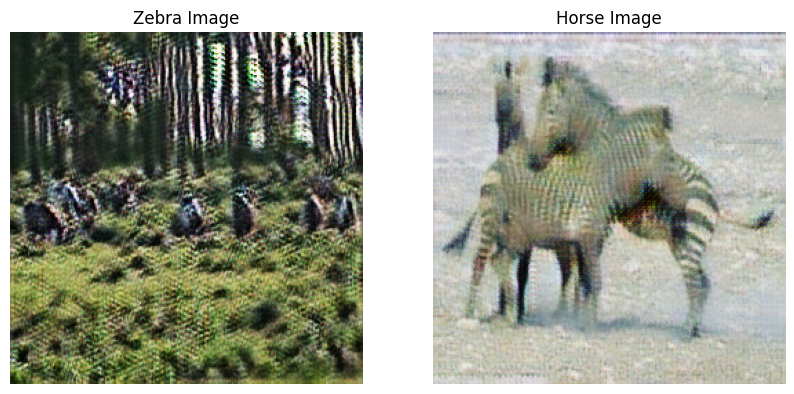

In [19]:

zebra_image_path = '/kaggle/working/saved_images/zebra_1000.png'
horse_image_path = '/kaggle/working/saved_images/horse_1000.png'

zebra_image = Image.open(zebra_image_path)
horse_image = Image.open(horse_image_path)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Zebra Image")
plt.imshow(zebra_image)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Horse Image")
plt.imshow(horse_image)
plt.axis('off')

plt.show()